# LSTM con datos de viento en Cuenca

Se importan las librerías.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Se importan los datos.

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')

In [ ]:
df = df[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]

In [ ]:
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')

In [ ]:
df_test = df_test[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]

In [ ]:
velocidad_viento = df['WS1HA'].values

In [ ]:
import statsmodels.graphics.tsaplots as sgt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Análisis de autocorrelación.

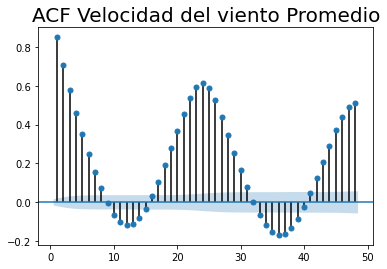

In [ ]:
sgt.plot_acf(velocidad_viento, lags = 48, zero = False)
plt.title("ACF Velocidad del viento Promedio", size = 20)
plt.show()

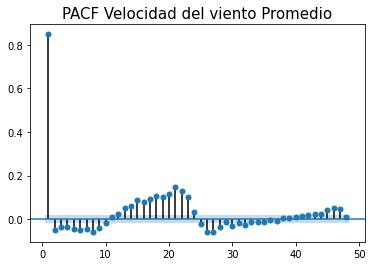

In [ ]:
sgt.plot_pacf(velocidad_viento, lags = 48, zero = False, method = ('ols'))
plt.title("PACF Velocidad del viento Promedio", size = 15)
plt.show()

In [ ]:
velocidad_viento = np.reshape(velocidad_viento,(-1,1))

In [ ]:
velocidad_viento_test = df_test['WS1HA'].values
velocidad_viento_test = np.reshape(velocidad_viento_test,(-1,1))

## Modelo AR

Se creará un modelo AR que servirá de referencia.

In [ ]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

Se importa la librería para realizar una búsqueda del mejor modelo AR.

In [ ]:
from statsmodels.tsa.ar_model import AR

In [ ]:
model = AR(df['WS1HA'])
ARfit = model.fit(maxlag=48,ic='bic') 
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 28
Coefficients:
const        0.207770
L1.WS1HA     0.760548
L2.WS1HA    -0.016077
L3.WS1HA     0.000998
L4.WS1HA     0.013141
L5.WS1HA     0.009231
L6.WS1HA     0.002767
L7.WS1HA     0.014599
L8.WS1HA    -0.009329
L9.WS1HA    -0.007011
L10.WS1HA   -0.015566
L11.WS1HA   -0.004139
L12.WS1HA   -0.011600
L13.WS1HA    0.001925
L14.WS1HA   -0.018531
L15.WS1HA    0.016056
L16.WS1HA   -0.002663
L17.WS1HA   -0.000195
L18.WS1HA    0.019879
L19.WS1HA    0.010009
L20.WS1HA   -0.004381
L21.WS1HA    0.046295
L22.WS1HA    0.051081
L23.WS1HA    0.077785
L24.WS1HA    0.049039
L25.WS1HA    0.019718
L26.WS1HA   -0.015886
L27.WS1HA   -0.027731
L28.WS1HA   -0.038589
dtype: float64


El mejor modelo considera 28 retrasos.

In [ ]:
coef = ARfit.params

In [ ]:
coef

const        0.207770
L1.WS1HA     0.760548
L2.WS1HA    -0.016077
L3.WS1HA     0.000998
L4.WS1HA     0.013141
L5.WS1HA     0.009231
L6.WS1HA     0.002767
L7.WS1HA     0.014599
L8.WS1HA    -0.009329
L9.WS1HA    -0.007011
L10.WS1HA   -0.015566
L11.WS1HA   -0.004139
L12.WS1HA   -0.011600
L13.WS1HA    0.001925
L14.WS1HA   -0.018531
L15.WS1HA    0.016056
L16.WS1HA   -0.002663
L17.WS1HA   -0.000195
L18.WS1HA    0.019879
L19.WS1HA    0.010009
L20.WS1HA   -0.004381
L21.WS1HA    0.046295
L22.WS1HA    0.051081
L23.WS1HA    0.077785
L24.WS1HA    0.049039
L25.WS1HA    0.019718
L26.WS1HA   -0.015886
L27.WS1HA   -0.027731
L28.WS1HA   -0.038589
dtype: float64

Se define una función para calcular las predicciones del modelo AR.

In [ ]:
def get_pred(coef,data):
  prediction = coef['const'] # constante
  # los datos se reciben en forma cronológica
  j = 1
  for i in range(len(data)-1,-1,-1):
    prediction += coef[j] * data[i]
    j+=1
  return prediction

In [ ]:
ARfit.predict(start=len(df),end=len(df)+2)

2016-08-07 20:00:00    3.405379
2016-08-07 21:00:00    3.197024
2016-08-07 22:00:00    3.091419
Freq: H, dtype: float64

In [ ]:
get_pred(coef,df['WS1HA'][-28:].values)

3.4053785296675216

In [ ]:
df_test['WS1HA'][0]

3.2

Se generan predicciones para todo el conjunto de pruebas.

In [ ]:
test_pred = []
retrasos = 28
for i in range(retrasos,len(df_test)):
  past_data = df_test.iloc[i-retrasos:i]['WS1HA'].values
  test_pred.append(get_pred(coef,past_data))

In [ ]:
test_pred = np.ndarray.flatten(np.array(test_pred))

In [ ]:
test_pred[:5]

array([3.09186717, 2.66249916, 2.86111717, 3.16321214, 2.94420981])

In [ ]:
test_pred.shape

(3481,)

In [ ]:
df_test.shape

(3509, 7)

In [ ]:
real_data = df_test.iloc[retrasos:]['WS1HA'].values
real_data = np.ndarray.flatten(np.array(real_data))
len(real_data)

3481

El RMSE es de 0.87 $\frac{m}{s}$

In [ ]:
errorAR = mean_squared_error(real_data,test_pred)
np.sqrt(errorAR)

0.8723885720775963

In [ ]:
mean_absolute_error(real_data,test_pred)

0.6239465102088289

## Buscando los mejores parámetros

Ahora, se construirá un modelo LSTM con optimización de hiperparámetros.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

Se normalizan los datos.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(velocidad_viento)
scaled_train = scaler.transform(velocidad_viento)
scaled_test = scaler.transform(velocidad_viento_test)

In [ ]:
scaled_train[0]

array([0.11111111])

Se importa la librería para generar batches de entrenamiento.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
import json

In [3]:
resultados_anteriores = []

Se importan resultados anteriores en caso de que existan, esto se debe a las limitaciones de tiempo de Colab.

In [4]:
with open("./drive/MyDrive/DatosInvestigacion/resultados_LSTM_univariado_viento.txt",'r') as fp:
    for line in fp:
      resultados_anteriores.append(json.loads(line))

In [5]:
df_resultados_anteriores = pd.DataFrame(resultados_anteriores)

Se importan las librerías para generar el modelo LSTM.

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
n_input = 10 # horas hacia atrás
n_features = 0 # variables exógenas

Se define una función para generar modelos con distinto número de capas y neuronas.

In [ ]:
def create_Model(n_input, LSTM_neurons = 100, layers=3,n_features=0):
  # define model
  model = Sequential()
  if(layers>1):
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1),return_sequences=True))
    for i in range(layers-2):
        model.add(LSTM(LSTM_neurons, activation='relu',return_sequences=True))
    model.add(LSTM(LSTM_neurons, activation='relu'))
  else:
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
model = create_Model(10,100,1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)  

In [ ]:
batch_size = 150

In [ ]:
model.fit(generator,epochs=7,verbose=True,batch_size=batch_size)


Epoch 1/7
14025/14025 [==============================] - 89s 6ms/step - loss: 0.0103
Epoch 2/7
14025/14025 [==============================] - 97s 7ms/step - loss: 0.0091
Epoch 3/7
14025/14025 [==============================] - 92s 7ms/step - loss: 0.0090
Epoch 4/7
14025/14025 [==============================] - 89s 6ms/step - loss: 0.0088
Epoch 5/7
14025/14025 [==============================] - 88s 6ms/step - loss: 0.0088
Epoch 6/7
14025/14025 [==============================] - 118s 8ms/step - loss: 0.0087
Epoch 7/7
14025/14025 [==============================] - 89s 6ms/step - loss: 0.0086


Se realiza un ejemplo de predicción y evaluación.

In [ ]:
predictions = []
for j in range(n_input,len(df_test)):
  model_input = scaled_test[j-n_input:j]
  model_input = model_input.reshape((1, n_input, n_features+1))
  predictions.append(model.predict(model_input)[0])
predictions = np.ndarray.flatten(np.array(predictions))  
true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))
true_values = np.ndarray.flatten(df_test.iloc[n_input:]['WS1HA'].values)
errorMSE = mean_squared_error(true_values,true_predictions)
errorMAE = mean_absolute_error(true_values,true_predictions)

In [ ]:
errorMAE

0.6902290663146128

In [6]:
resultados=[]
combinaciones_anteriores = []

In [7]:
df_resultados = df_resultados_anteriores

In [8]:
for i in range(len(df_resultados)):
  combinaciones_anteriores.append((int(df_resultados.iloc[i]['Retrasos']),
                                   int(df_resultados.iloc[i]['Neuronas LSTM']),
                                   int(df_resultados.iloc[i]['Batch size']),
                                   int(df_resultados.iloc[i]['LSTM Layers'])))

In [ ]:
len(combinaciones_anteriores)

108

In [ ]:
combinaciones_anteriores[-1]

(32, 100, 100, 1)

In [ ]:
df_resultados[df_resultados['RMSE']==df_resultados['RMSE'].min()]

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
45,24,100,50,1,0.727501,0.613977,0.852937


Se utiliza el mínimo RSME como referencia para elegir el mejor modelo.

In [ ]:
min_RMSE = 0.8529369387939835

Se realiza la búsqueda de los mejores parámetros.

In [ ]:
for retrasos in range(20,33,4): #hasta dos días y medio hacia el pasado
  for num_neuronas in range(50,101,25): 
    for batch_size in range(50,151,50):
      for num_layers in range(1,4): 
        if((retrasos,num_neuronas,batch_size,num_layers) in combinaciones_anteriores):
          continue
        print({
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'Batch size':batch_size,
            'LSTM Layers': num_layers,
        })
        n_input = retrasos # horas hacia atrás
        n_features = 0 # variables exógenas
        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)  
        model = create_Model(n_input,LSTM_neurons=num_neuronas,layers=num_layers)
        model.fit(generator,epochs=7,verbose=False,batch_size=batch_size)
        predictions = []
        for j in range(n_input,len(df_test)):
          model_input = scaled_test[j-n_input:j]
          model_input = model_input.reshape((1, n_input, n_features+1))
          predictions.append(model.predict(model_input)[0])
        predictions = np.ndarray.flatten(np.array(predictions))  
        true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))
        true_values = np.ndarray.flatten(df_test.iloc[n_input:]['WS1HA'].values)
        errorMSE = mean_squared_error(true_values,true_predictions)
        errorMAE = mean_absolute_error(true_values,true_predictions)
        errorRMSE = np.sqrt(errorMSE)
        print('RMSE',errorRMSE)
        print('MAE',errorMAE)
        print('Min RMSE',min_RMSE)
        if(errorRMSE<min_RMSE):
          print('BEST')
          model.save('./drive/MyDrive/DatosInvestigacion/LSTM_univariado_Viento.h5')
          min_RMSE = errorRMSE

        resultado = {
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'Batch size':batch_size,
            'LSTM Layers': num_layers,
            'MSE':errorMSE,
            'MAE':errorMAE,
            'RMSE':errorRMSE
        }
        with open("./drive/MyDrive/DatosInvestigacion/resultados_LSTM_univariado_viento.txt","a") as file:
          resultado = json.dumps(resultado)
          file.write(resultado)
          file.write('\n')

{'Retrasos': 32, 'Neuronas LSTM': 100, 'Batch size': 100, 'LSTM Layers': 2}
RMSE 0.8695346463004078
MAE 0.620494382281841
Min RMSE 0.8529369387939835
{'Retrasos': 32, 'Neuronas LSTM': 100, 'Batch size': 100, 'LSTM Layers': 3}
RMSE 0.882662476768732
MAE 0.6454028996870647
Min RMSE 0.8529369387939835
{'Retrasos': 32, 'Neuronas LSTM': 100, 'Batch size': 150, 'LSTM Layers': 1}
RMSE 0.8998044409414245
MAE 0.6345944216475425
Min RMSE 0.8529369387939835
{'Retrasos': 32, 'Neuronas LSTM': 100, 'Batch size': 150, 'LSTM Layers': 2}
RMSE 0.8750889577876831
MAE 0.6272583895650855
Min RMSE 0.8529369387939835
{'Retrasos': 32, 'Neuronas LSTM': 100, 'Batch size': 150, 'LSTM Layers': 3}
RMSE 0.9137148209177316
MAE 0.6704527491497382
Min RMSE 0.8529369387939835


Se guardan los resultados como csv.

In [10]:
df_resultados.to_csv('./drive/MyDrive/DatosInvestigacion/lstm_viento_resultados.csv',index=False)

In [11]:
df_resultados = pd.read_csv('./drive/MyDrive/DatosInvestigacion/lstm_viento_resultados.csv')

In [12]:
df_resultados.head()

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
0,24,50,50,1,0.743698,0.621528,0.862379
1,24,50,50,2,0.753384,0.621339,0.867977
2,24,50,50,3,0.778511,0.636489,0.882333
3,24,50,100,1,0.886013,0.724489,0.941283
4,24,50,100,2,0.807436,0.641749,0.898575


Comparar con otros modelos

In [13]:
df_resultados[df_resultados['MAE'] == df_resultados['MAE'].min()]

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
45,24,100,50,1,0.727501,0.613977,0.852937


In [14]:
df_resultados[df_resultados['RMSE'] == df_resultados['RMSE'].min()]

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
45,24,100,50,1,0.727501,0.613977,0.852937


## Gráficas de los resultados

In [15]:
import seaborn as sns

### Número de retrasos

El mejor número de retrasos es 24.

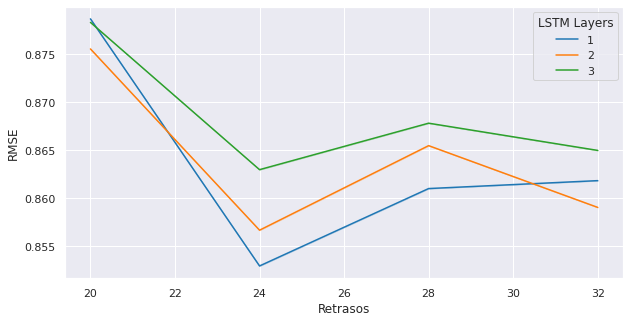

In [16]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Retrasos', y='RMSE',hue='LSTM Layers',palette='tab10',ci=0, estimator=np.min)

### Número de neuronas

El mejor número de neuronas es 100.

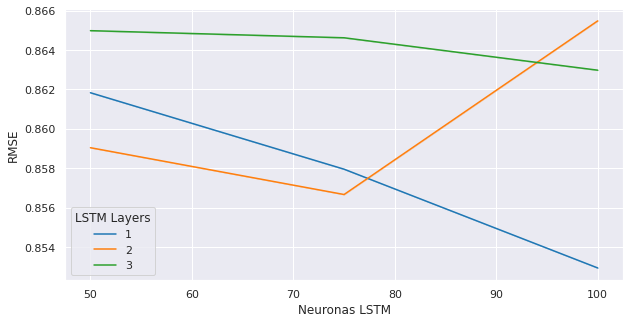

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Neuronas LSTM', y='RMSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

### Batch size

El mejor batch size es 50.

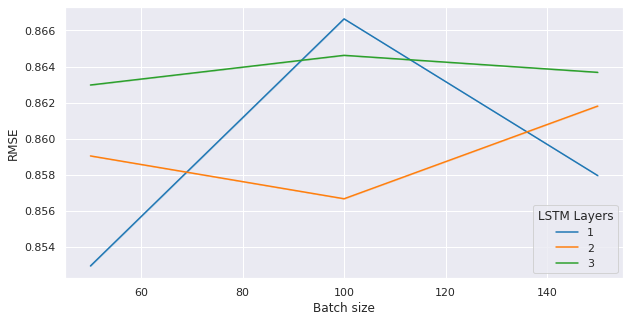

In [ ]:
  sns.set(rc={"figure.figsize":(10, 5)})
  sns.lineplot(data=df_resultados, x='Batch size', y='RMSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

### Conclusiones

* 1 capa LSTM es mejor
* El mejor batch size es de 50
* El mejor número de retrasos es 24 (un día entero)
* El mejor número de neuronas es 100